In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import eispac
import irispy.io

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

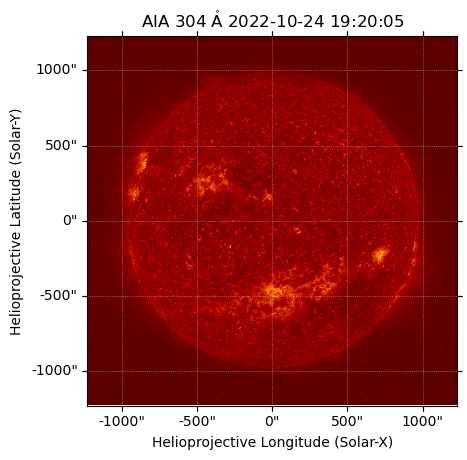

In [3]:
aia_304_map = sunpy.map.Map("../../src/AIA/20221024/304/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.304.image.fits")
aia_304_map.plot()

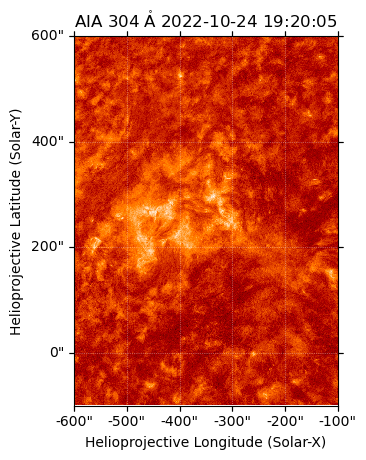

In [4]:
aia_304_map_crop = aia_304_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_304_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_304_map.coordinate_frame))
aia_304_map_crop.plot()

In [5]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift
    

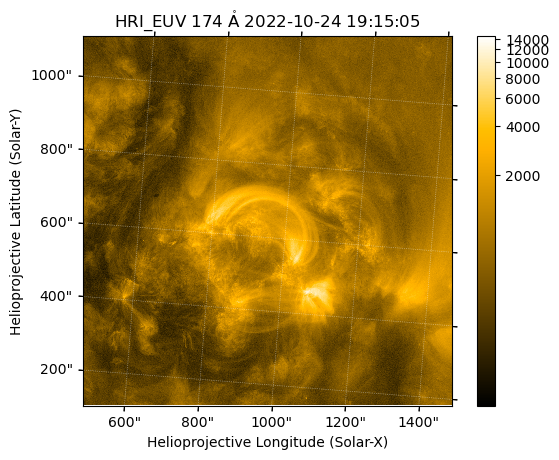

In [6]:
hri_174_map = sunpy.map.Map("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hrieuv174-image_20221024T191505172_V01.fits")
hri_174_map.plot()
plt.colorbar()

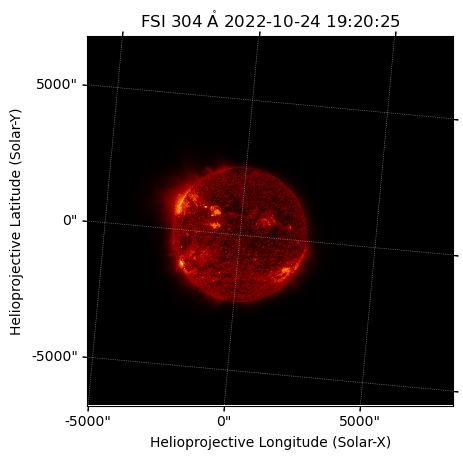

In [7]:
fsi_304_map = sunpy.map.Map("../../src/EUI/FSI/euv304/20221024/solo_L2_eui-fsi304-image_20221024T192020179_V01.fits")
fsi_304_map.plot()

In [8]:
def derotate_fsi(fsi_map, hri_map,algorithm="adaptive"):
    out_frame = hri_map.coordinate_frame
    out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
    header = sunpy.map.make_fitswcs_header(fsi_map.data.shape,
                                        out_center,
                                        scale=u.Quantity(fsi_map.scale),
                                        rotation_matrix=hri_map.rotation_matrix) 
    # correct the tiny rotation matrix difference between FSI and HRI, which simply the coalignment
    out_wcs = WCS(header)

    with propagate_with_solar_surface():
        fsi_map_derot = fsi_map.reproject_to(out_wcs,algorithm=algorithm)

    return fsi_map_derot


In [9]:
fsi_304_map_hri_time = derotate_fsi(fsi_304_map,hri_174_map)

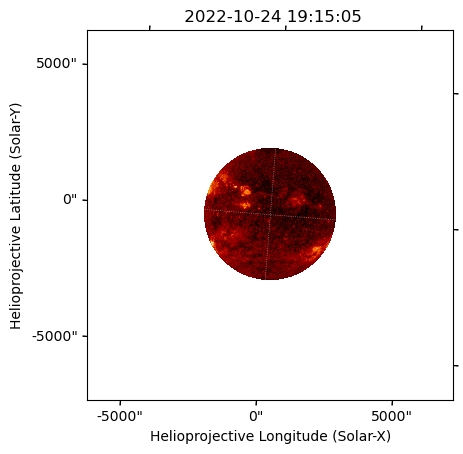

In [10]:
fsi_304_map_hri_time.plot()

In [11]:
fsi_304_crop = fsi_304_map_hri_time.submap(SkyCoord(500*u.arcsec,0*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame),
                                    top_right=SkyCoord(2000*u.arcsec,1250*u.arcsec,frame=fsi_304_map_hri_time.coordinate_frame))

In [12]:
aia_304_map_repro = aia_304_map.reproject_to(fsi_304_crop.wcs)

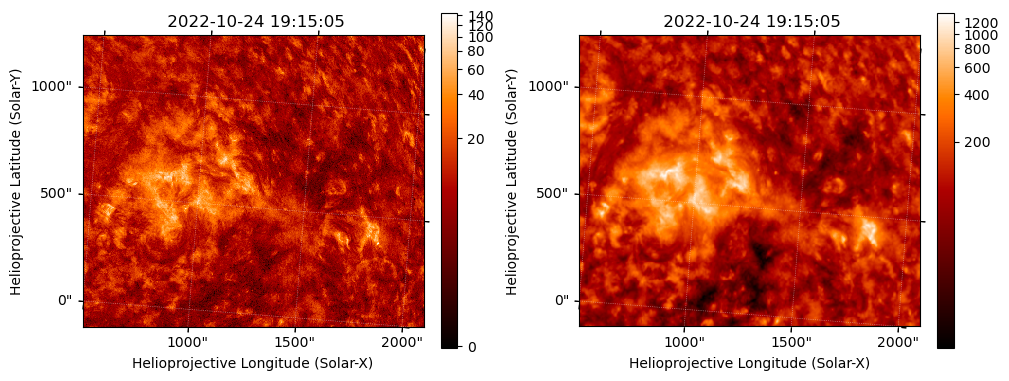

In [13]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=aia_304_map_repro)
im1 = aia_304_map_repro.plot()
plt.colorbar(ax=ax1,shrink=0.75)

ax2 = fig.add_subplot(122,projection=fsi_304_crop)
im2 = fsi_304_crop.plot()
plt.colorbar(ax=ax2,shrink=0.75)

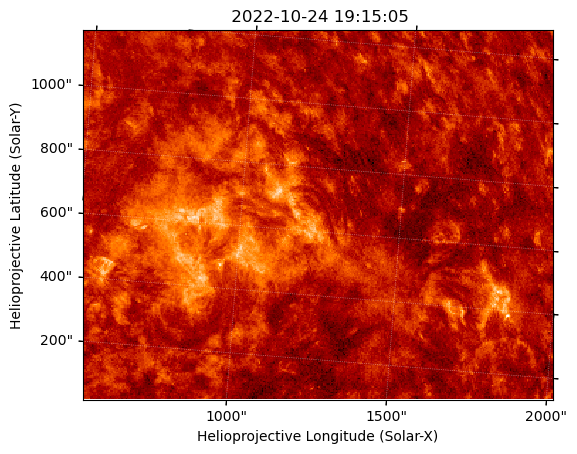

In [14]:
aia_304_map_repro_cut = aia_304_map_repro.submap([12,30]*u.pix,
                                                    top_right=[343,290]*u.pix)
aia_304_map_repro_cut.plot()

In [15]:
Txshift_aia_fsi, Tyshift_aia_fsi = coalign_shift(fsi_304_crop,aia_304_map_repro_cut)
print(Txshift_aia_fsi, Tyshift_aia_fsi)

-1.40322 arcsec 2.32321 arcsec


In [16]:
aia_304_map_repro_shift = aia_304_map_repro.shift_reference_coord(Txshift_aia_fsi,Tyshift_aia_fsi)

In [17]:
fsi_304_map_shift_toaia = fsi_304_map_hri_time.shift_reference_coord(-Txshift_aia_fsi,-Tyshift_aia_fsi)
fsi_304_map_shift_repro_toaia = fsi_304_map_shift_toaia.reproject_to(aia_304_map_crop.wcs)

In [18]:
print(coalign_shift(aia_304_map_crop,
                    fsi_304_map_shift_repro_toaia.submap([50,50]*u.pix,top_right=[700,1000]*u.pix)))

(<Angle 0.81878888 arcsec>, <Angle -0.01469037 arcsec>)


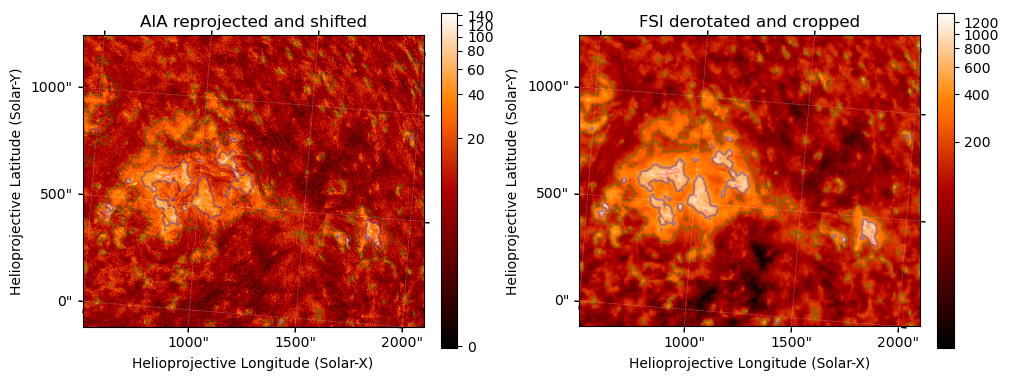

In [19]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=aia_304_map_repro_shift)
im1 = aia_304_map_repro_shift.plot()
plt.colorbar(ax=ax1,shrink=0.75)
ax1.set_title("AIA reprojected and shifted")

ax2 = fig.add_subplot(122,projection=fsi_304_crop)
im2 = fsi_304_crop.plot()
plt.colorbar(ax=ax2,shrink=0.75)
ax2.set_title("FSI derotated and cropped")

fsi_304_levels = [200,500,1000]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    fsi_304_crop.draw_contours(fsi_304_levels,colors=["g","b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)


In [20]:
SunBlinker(aia_304_map_repro_shift, fsi_304_map_hri_time, reproject=True)

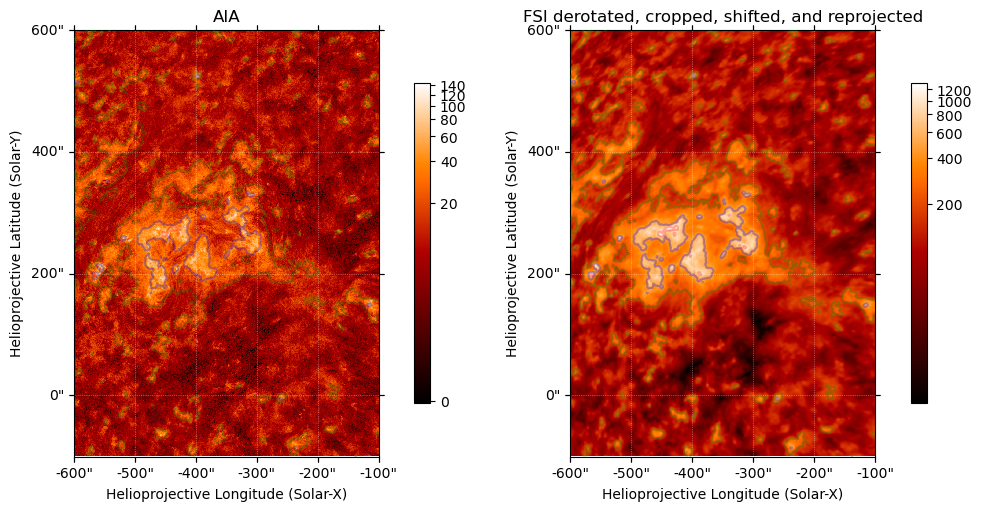

In [21]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(121,projection=aia_304_map_crop)
im1 = aia_304_map_crop.plot()
plt.colorbar(ax=ax1,shrink=0.75)
ax1.set_title("AIA")

ax2 = fig.add_subplot(122,projection=fsi_304_map_shift_repro_toaia)
im2 = fsi_304_map_shift_repro_toaia.plot()
plt.colorbar(ax=ax2,shrink=0.75)
ax2.set_title("FSI derotated, cropped, shifted, and reprojected")

fsi_304_levels = [200,500,1000]

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    fsi_304_map_shift_repro_toaia.draw_contours(fsi_304_levels,colors=["g","b","r"], axes=ax_, alpha=0.3)
    ax_.axis(bounds)


In [22]:
SunBlinker(aia_304_map_crop, fsi_304_map_shift_repro_toaia)